In [455]:
import pandas as pd

In [456]:
df = pd.read_csv('src/cleanedData.csv', usecols=['date_time', 'dp_PGCT'])
df.head()

,dp_PGCT,date_time
0,15.107864,2021-01-14 12:00:00
1,15.273140,2021-01-15 00:00:00
2,14.481785,2021-01-16 00:00:00
3,14.554796,2021-01-16 12:00:00
4,14.589597,2021-01-17 12:00:00


In [457]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df.head()

,dp_PGCT
date_time,
2021-01-14 12:00:00,15.107864
2021-01-15 00:00:00,15.273140
2021-01-16 00:00:00,14.481785
2021-01-16 12:00:00,14.554796
2021-01-17 12:00:00,14.589597


In [458]:
# Generate a date range with the expected dates
expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='12h')

# Find the missing dates
missing_dates = expected_dates.difference(df.index)

# Print the missing dates
print("Missing dates:")
len(missing_dates)

Missing dates:


182

In [459]:
# Reindex the dataframe to include the missing dates
df = df.reindex(expected_dates)

In [460]:
# Forward fill the missing values
df['dp_PGCT'].ffill(inplace=True)

C:\Users\athhatek\AppData\Local\Temp\ipykernel_13232\2941701528.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dp_PGCT'].ffill(inplace=True)


In [461]:
from matplotlib import pyplot as plt

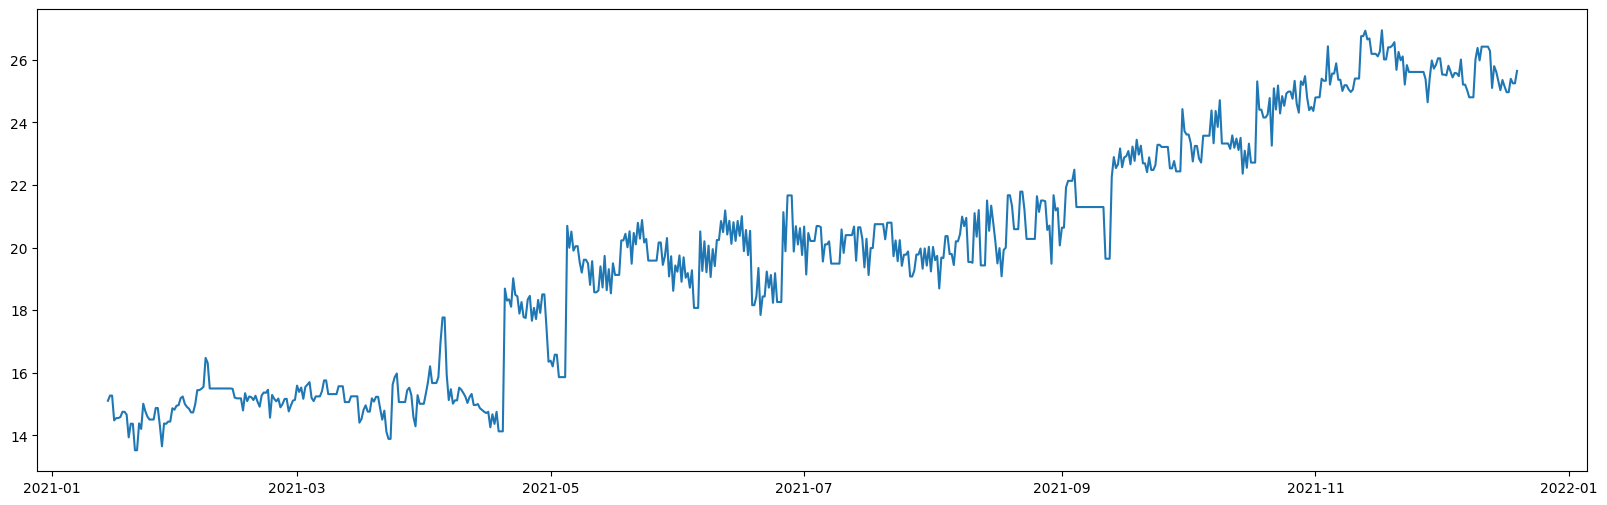

In [462]:
plt.figure(figsize=(20, 6))
plt.plot(df['dp_PGCT'])
plt.show()

In [463]:
#Check Stationarity of the data
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print('Augmented Dickey-Fuller Test:{}'.format(result[0]))
    print('p-value:{}'.format(result[1]))
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

In [464]:
adf_test(df['dp_PGCT'])

Augmented Dickey-Fuller Test:-0.5105050490397616
p-value:0.8899501523786878
Non-Stationary


In [465]:
## Use Techniques Differencing
df['dp_PGCT_diff1']=df['dp_PGCT']-df['dp_PGCT'].shift(1)
df.head()

,dp_PGCT,dp_PGCT_diff1
2021-01-14 12:00:00,15.107864,NaN
2021-01-15 00:00:00,15.273140,0.165277
2021-01-15 12:00:00,15.273140,0.000000
2021-01-16 00:00:00,14.481785,-0.791355
2021-01-16 12:00:00,14.554796,0.073011


In [466]:
adf_test(df['dp_PGCT_diff1'].dropna())

Augmented Dickey-Fuller Test:-8.81570232427194
p-value:1.9370366890667312e-14
Stationary


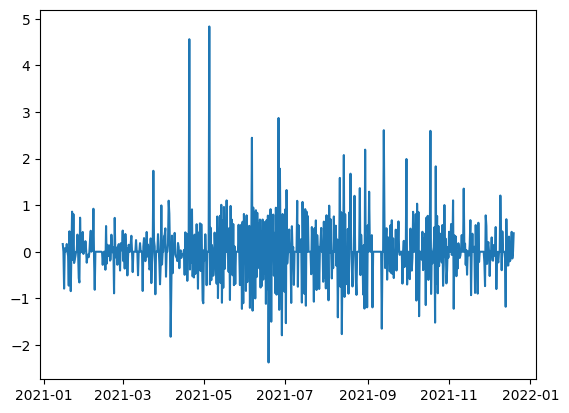

In [467]:
plt.plot(df['dp_PGCT_diff1'])

In [468]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

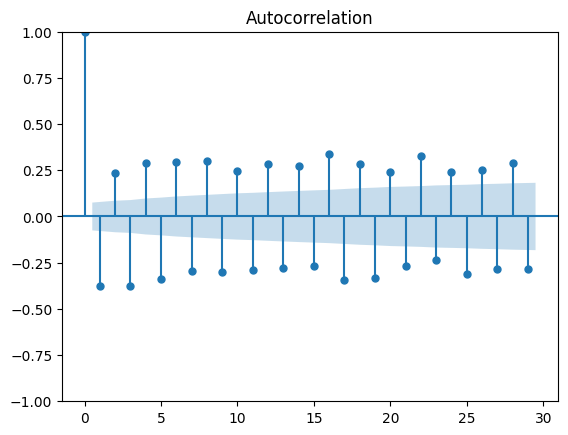

In [469]:
acf = plot_acf(df['dp_PGCT_diff1'].dropna())

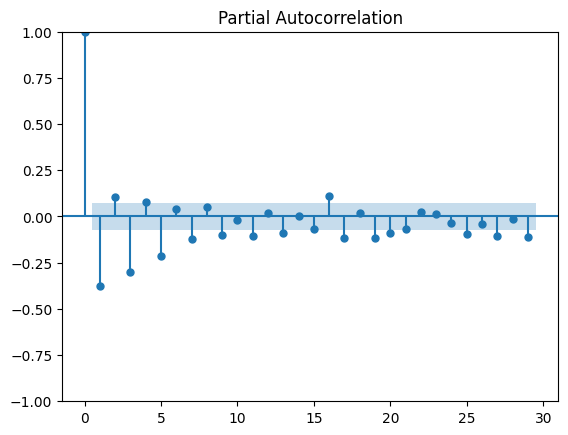

In [470]:
pacf = plot_pacf(df['dp_PGCT_diff1'].dropna())

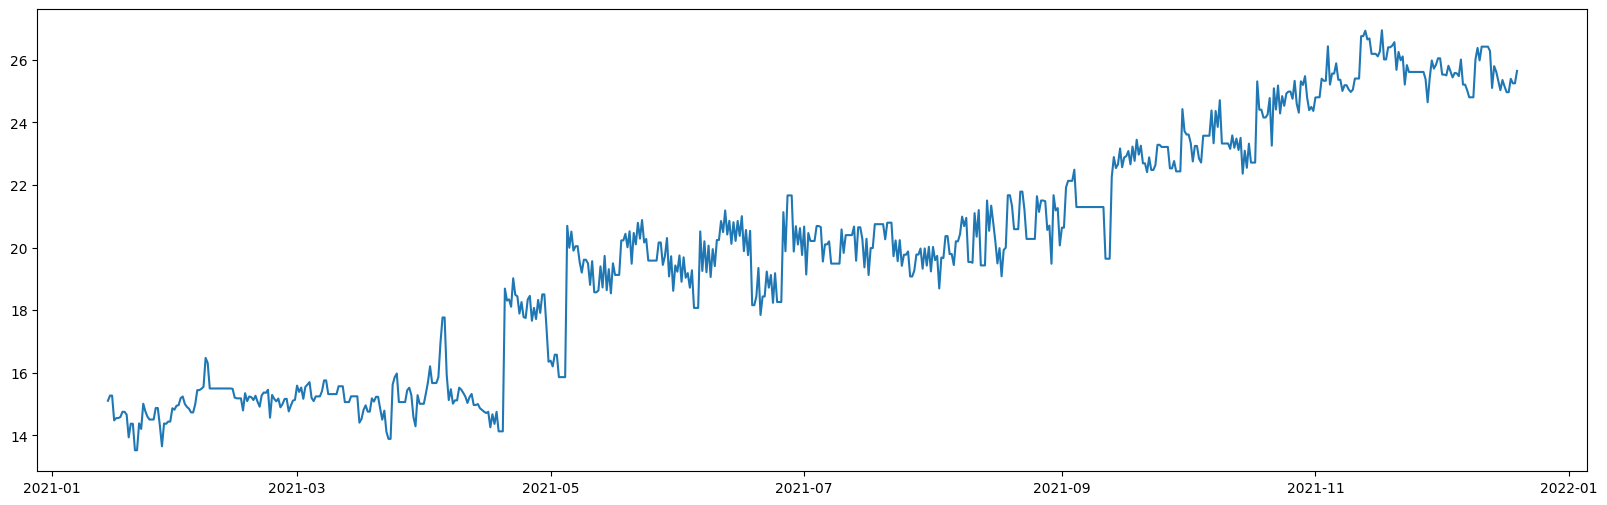

In [471]:
plt.figure(figsize=(20, 6))
plt.plot(df['dp_PGCT'])
plt.show()

# Split Data

In [488]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2021,5,31)
test_dataset_end=datetime(2021,6,15)

train_data=df[:train_dataset_end]
test_data=df[train_dataset_end : test_dataset_end]

##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [489]:
from statsmodels.tsa.arima.model import ARIMA
model_Arima=ARIMA(train_data['dp_PGCT'],order=(5,1,5))

In [490]:
model_Arima_fit=model_Arima.fit()

c:\Users\athhatek\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\athhatek\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\athhatek\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [491]:
pred = model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)

<Axes: ylabel='Density'>

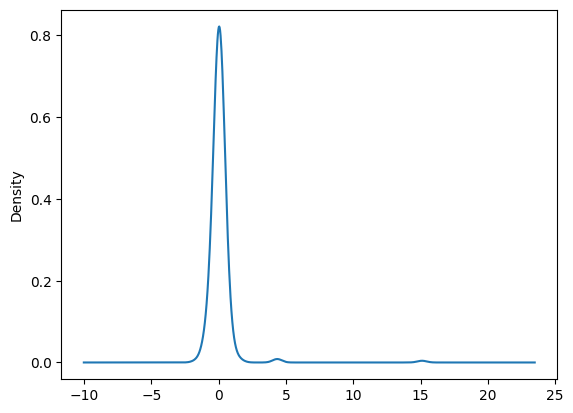

In [492]:
model_Arima_fit.resid.plot(kind='kde')

In [493]:
test_data['predicted_ARIMA'] = pred

C:\Users\athhatek\AppData\Local\Temp\ipykernel_13232\3272576283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_ARIMA'] = pred


<Axes: >

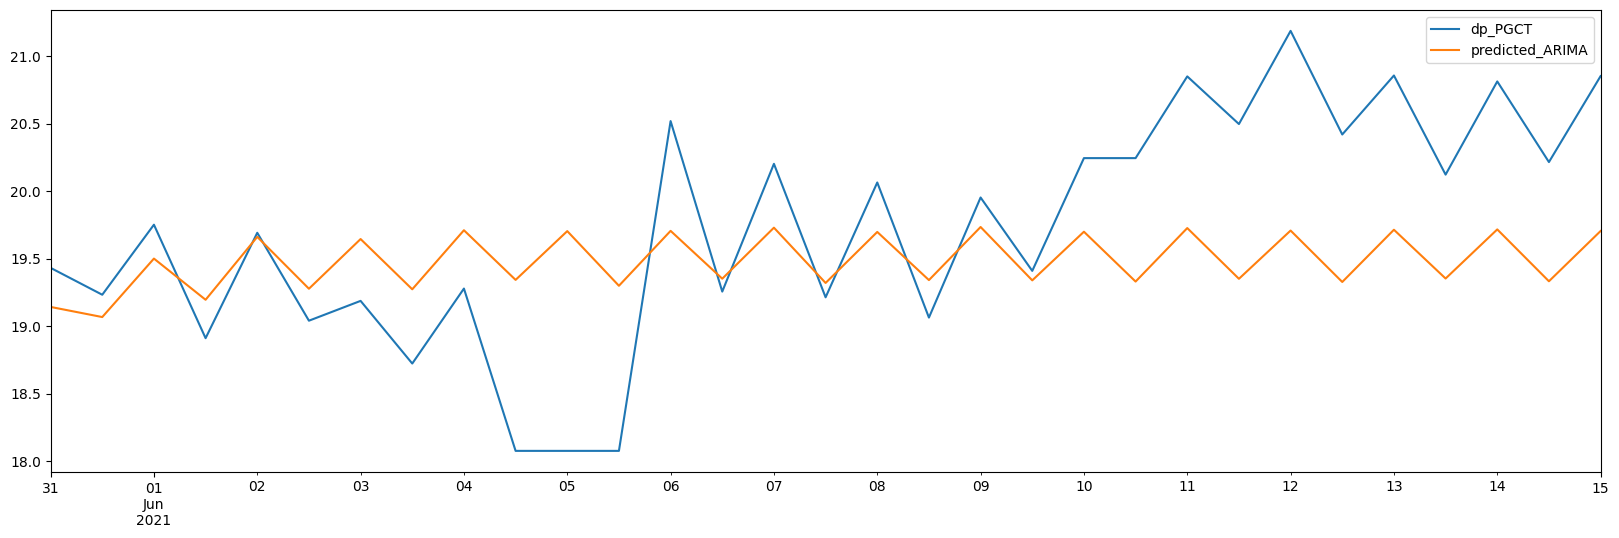

In [494]:
test_data[['dp_PGCT','predicted_ARIMA']].plot(figsize=(20,6))

In [495]:
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [496]:
model_SARIMA=SARIMAX(train_data['dp_PGCT'],order=(0,0,0),seasonal_order=(3,1,3,12))

In [497]:
model_SARIMA_fit=model_SARIMA.fit()

In [498]:
pred_SARIMA = model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)

In [499]:
test_data['Predicted_SARIMA']=pred_SARIMA

C:\Users\athhatek\AppData\Local\Temp\ipykernel_13232\1258061164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMA']=pred_SARIMA


In [500]:
test_data.head()

,dp_PGCT,dp_PGCT_diff1,predicted_ARIMA,Predicted_SARIMA
2021-05-31 00:00:00,19.431704,0.810528,19.142039,20.392276
2021-05-31 12:00:00,19.232463,-0.199241,19.067032,19.893301
2021-06-01 00:00:00,19.751777,0.519314,19.500543,20.144218
2021-06-01 12:00:00,18.910331,-0.841446,19.195180,19.535394
2021-06-02 00:00:00,19.691864,0.781533,19.661638,20.516724


<Axes: >

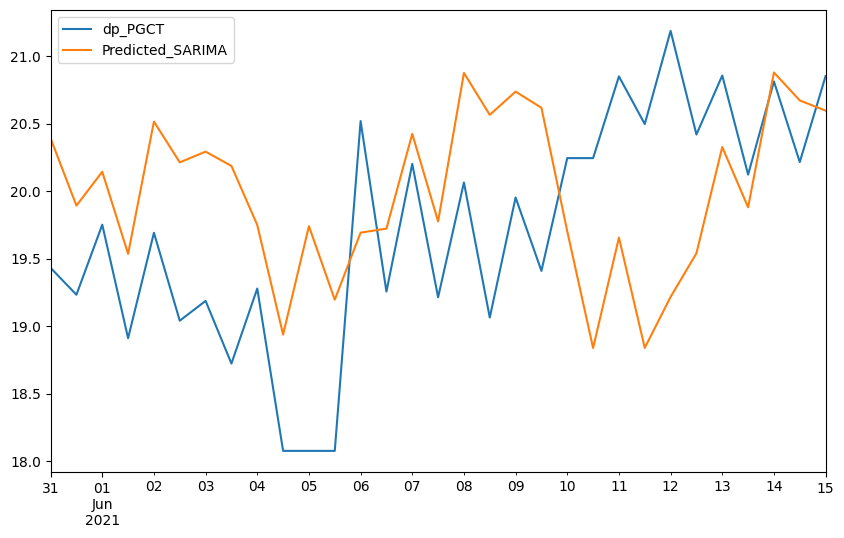

In [501]:
test_data[['dp_PGCT','Predicted_SARIMA']].plot(figsize=(10,6))

In [514]:
# Fit a linear regression line to the predicted values
import numpy as np
x = np.arange(len(pred))
y = pred
slope, intercept = np.polyfit(x, y, 1)
linear_fit = slope * x + intercept

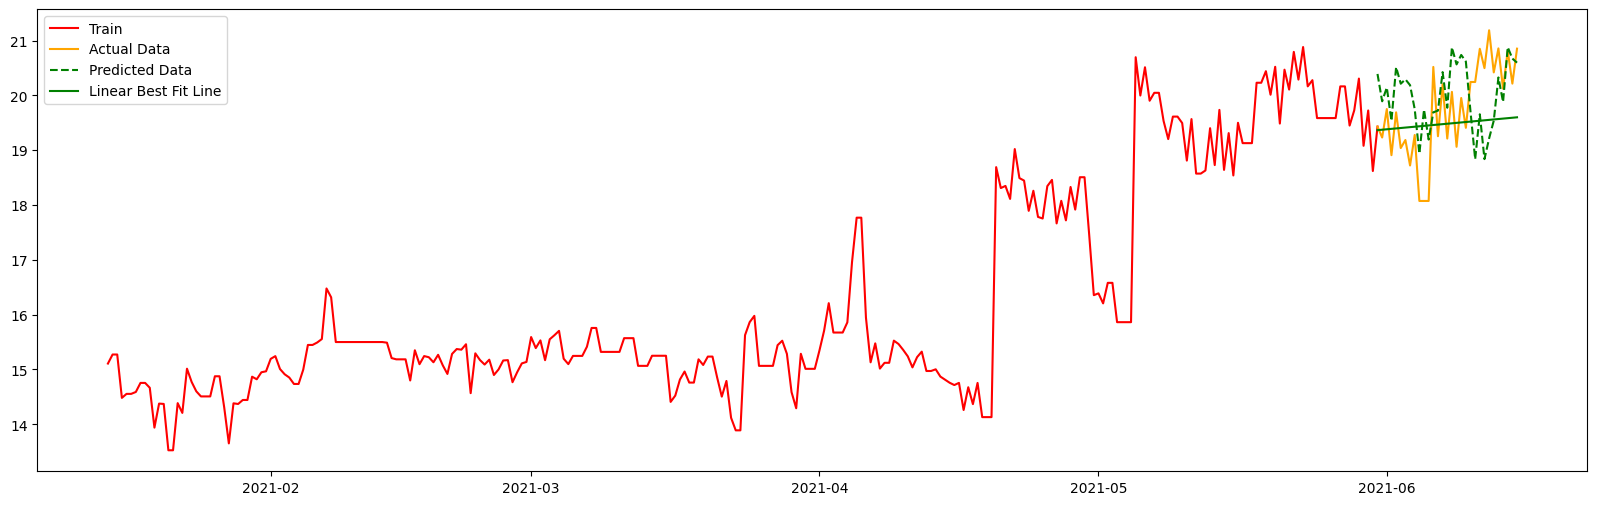

In [515]:
plt.figure(figsize=(20, 6))
plt.plot(train_data['dp_PGCT'], label='Train', color='red')
plt.plot(test_data['dp_PGCT'], label='Actual Data', color='orange')
plt.plot(test_data['Predicted_SARIMA'], label='Predicted Data', color='green',linestyle='--')
plt.plot(pred.index,linear_fit, label='Linear Best Fit Line', color='green')
plt.legend()
plt.show()